In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error, reset_error, thermal_relaxation_error
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification import marginal_counts
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [3]:
sim = Aer.get_backend('qasm_simulator')

# Build noise model from backend properties
backend = provider.get_backend('ibmq_quito')

# Get noise model from real device 'ibmq_quito'
noise_model_device = NoiseModel.from_backend(backend)
# print(noise_model_device)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model_device.basis_gates

T1 = backend.properties().t1(0) * 1e9
T2 = backend.properties().t2(0) * 1e9
duration_x = backend.properties().gate_length("x", 0) * 1e9
duration_cx = backend.properties().gate_length("cx", {0, 1}) * 1e9
duration_meas = backend.properties().readout_length(0) * 1e9
duration_reset = duration_meas

print("T1: %.3f ns"%T1)
print("T2: %.3f ns"%T2)
print("duration_x: %.3f ns"%duration_x)
print("duration_cx: %.3f ns"%duration_cx)
print("duration_meas: %.3f ns"%duration_meas)
print("duration_reset: %.3f ns"%duration_reset)


T1: 87853.058 ns
T2: 119964.492 ns
duration_x: 35.556 ns
duration_cx: 234.667 ns
duration_meas: 5351.111 ns
duration_reset: 5351.111 ns


In [4]:
# build a customised noise model
def build_noise_model(p_meas, p_depo, p_reset, thermal, n_qubits):
    noise_model = NoiseModel()
    
    if thermal:
        # T1 and T2 values for all qubits (following normal distribution)
        T1s = np.random.normal(T1, 10e3, n_qubits)
        T2s = np.random.normal(T2, 10e3, n_qubits)

        # Ensure T2 <= 2T1
        T2s = np.array([min(T2s[i], 2 * T1s[i]) for i in range(n_qubits)])
        
        errors_measure = [thermal_relaxation_error(t1, t2, duration_meas)
                      for t1, t2 in zip(T1s, T2s)]
        errors_x  = [thermal_relaxation_error(t1, t2, duration_x)
                      for t1, t2 in zip(T1s, T2s)]
        errors_cx = [[thermal_relaxation_error(t1a, t2a, duration_cx).expand(
                     thermal_relaxation_error(t1b, t2b, duration_cx))
                      for t1a, t2a in zip(T1s, T2s)]
                       for t1b, t2b in zip(T1s, T2s)]
        
        for i in range(n_qubits):
            if p_meas > 0:
                # add thermal measurement noise to measurements
                noise_model.add_quantum_error(errors_measure[i], "measure", [i])
            if p_depo > 0:
                # add thermal gate noise to X-gates
                noise_model.add_quantum_error(errors_x[i], "x", [i])
                # add thermal gate noise to CX-gates
                for j in range(n_qubits):
                    noise_model.add_quantum_error(errors_cx[i][j], "cx", [i, j])
    
    else:
        # measurement noise: probability of p_meas to flip the resulting state
        error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
        # depolarizing noise: probability of p_depo to change the state into a random state
        error_gate1 = depolarizing_error(p_depo, 1)  # noise in a single-qubit gate
        error_gate2 = depolarizing_error(p_depo, 2)  # noise in a two-qubit gate
        # reset noise: probability of p_reset to flip the initialised state
        error_reset = reset_error(1 - p_reset, p_reset)
        
        # add measurement noise to measurements
        noise_model.add_all_qubit_quantum_error(error_meas, "measure")
        # add single-qubit gate noise to X-gates and H-gates
        noise_model.add_all_qubit_quantum_error(error_gate1, ["x", "h"])
        # add two-qubit gate noise to CX-gates
        noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
        # add reset noise to initialisations
        noise_model.add_all_qubit_quantum_error(error_reset, "reset")
    
    return noise_model


In [5]:
def simulate(circuit, noise_model=None):
    if noise_model == None:
        # Perform a noiseless simulation
        result = execute(circuit, backend=sim, shots=10000).result()
        return result.get_counts()
    
    # Perform a noisy simulation with an indicated noise model
    result_noisy = execute(circuit, backend=sim, shots=10000, noise_model=noise_model).result()
    return result_noisy.get_counts()


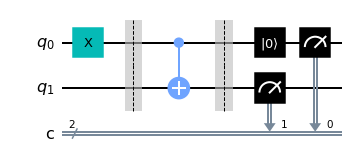

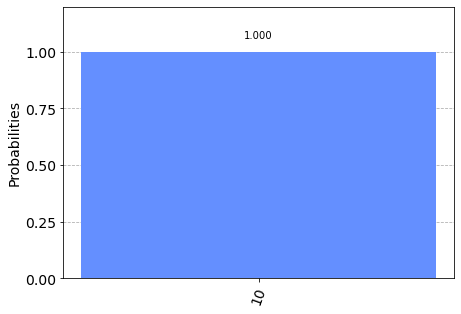

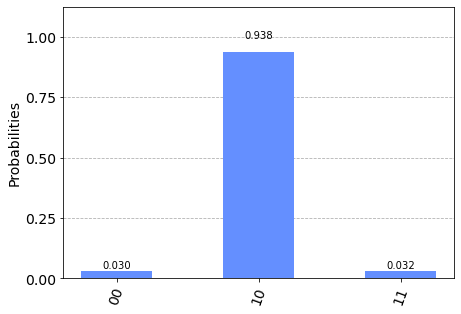

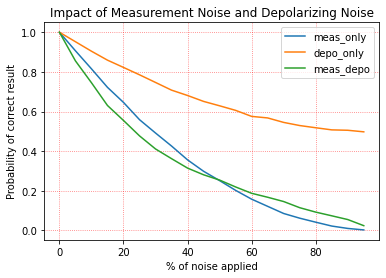

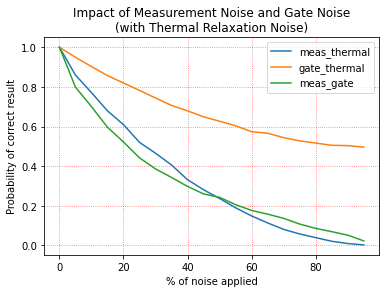

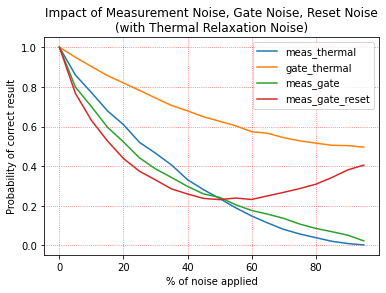

In [20]:
# XOR Gate
xor_circ = QuantumCircuit(2, 2)
xor_circ.x(0)
xor_circ.barrier()
xor_circ.cx(0, 1)
xor_circ.barrier()
# the reset error will be applied just before the measurement
xor_circ.reset(0)
xor_circ.measure([0, 1], [0, 1])
display(xor_circ.draw('mpl'))

# Perform a noiseless simulation
counts_perfect = simulate(xor_circ)
display(plot_histogram(counts_perfect))

# # Run the circuit on a real quantum computer
# job = execute(xor_circ, backend=backend)
# job_monitor(job)
# result_real = job.result()
# counts_real = result_real.get_counts()
# display(plot_histogram(counts_real))

# Perform a noisy simulation (device)
result_device = execute(xor_circ, backend=sim,
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model_device).result()
counts_device = result_device.get_counts()
display(plot_histogram(counts_device))

# Probabilities of correct results under three types of noise
meas_only = []
depo_only = []
meas_depo = []

# Perform noisy simulations with pure measurement noise and depolarizing noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    meas_noise_model = build_noise_model((i / 100), 0, 0, False, 2)
    counts_meas_only = simulate(xor_circ, meas_noise_model)
    meas_only.append(counts_meas_only['10'] / 10000)
    
    depo_noise_model = build_noise_model(0, (i / 100), 0, False, 2)
    counts_depo_only = simulate(xor_circ, depo_noise_model)
    depo_only.append(counts_depo_only['10'] / 10000)
    
    meas_depo_noise_model = build_noise_model((i / 100), (i / 100), 0, False, 2)
    counts_meas_depo = simulate(xor_circ, meas_depo_noise_model)
    meas_depo.append(counts_meas_depo['10'] / 10000)

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_only)
plt.plot(range(0, 100, 5), depo_only)
plt.plot(range(0, 100, 5), meas_depo)
plt.title('Impact of Measurement Noise and Depolarizing Noise')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_only', 'depo_only', 'meas_depo'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()

# Probabilities of correct results under three types of noise
meas_thermal = []
gate_thermal = []
meas_gate = []
index = 0

# Perform noisy simulations with mixed measurement noise and gate noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    meas_noise_model = build_noise_model((i / 100), 0, 0, True, 2)
    counts_meas_thermal = simulate(xor_circ, meas_noise_model)
    meas_thermal.append(meas_only[index] * counts_meas_thermal['10'] / 10000)
    
    gate_noise_model = build_noise_model(0, (i / 100), 0, True, 2)
    counts_gate_thermal = simulate(xor_circ, gate_noise_model)
    gate_thermal.append(depo_only[index] * counts_gate_thermal['10'] / 10000)
    
    meas_gate_noise_model = build_noise_model((i / 100), (i / 100), 0, True, 2)
    counts_meas_gate = simulate(xor_circ, meas_gate_noise_model)
    meas_gate.append(meas_depo[index] * counts_meas_gate['10'] / 10000)
    
    index += 1

meas_gate_reset = []

# Perform noisy simulations with reset noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    total_noise_model = build_noise_model((i / 100), (i / 100), (i / 100), False, 2)
    counts_total = simulate(xor_circ, total_noise_model)
    meas_gate_noise_model = build_noise_model((i / 100), (i / 100), 0, True, 2)
    counts_meas_gate = simulate(xor_circ, meas_gate_noise_model)
    meas_gate_reset.append((counts_total['10'] / 10000) * (counts_meas_gate['10'] / 10000))

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_thermal)
plt.plot(range(0, 100, 5), gate_thermal)
plt.plot(range(0, 100, 5), meas_gate)
plt.title('Impact of Measurement Noise and Gate Noise\n(with Thermal Relaxation Noise)')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_thermal', 'gate_thermal', 'meas_gate'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_thermal)
plt.plot(range(0, 100, 5), gate_thermal)
plt.plot(range(0, 100, 5), meas_gate)
plt.plot(range(0, 100, 5), meas_gate_reset)
plt.title('Impact of Measurement Noise, Gate Noise, Reset Noise\n(with Thermal Relaxation Noise)')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_thermal', 'gate_thermal', 'meas_gate', 'meas_gate_reset'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()


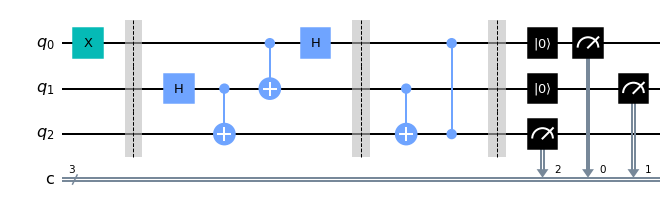

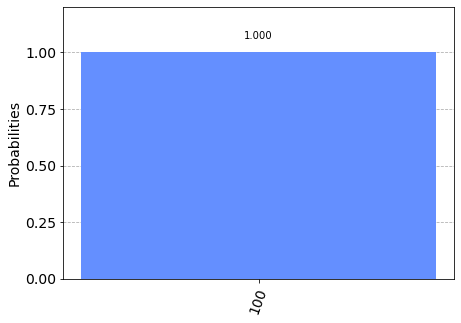

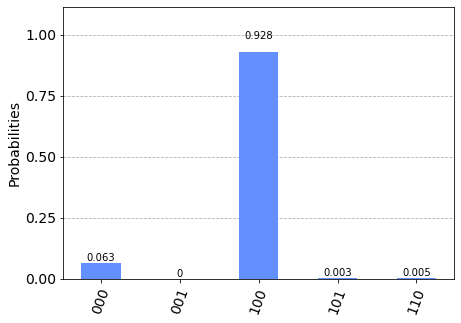

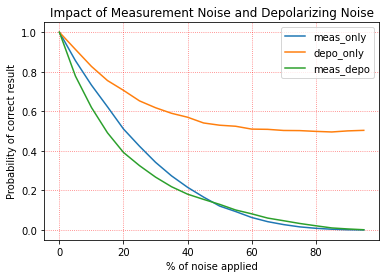

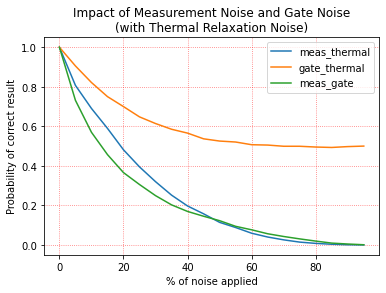

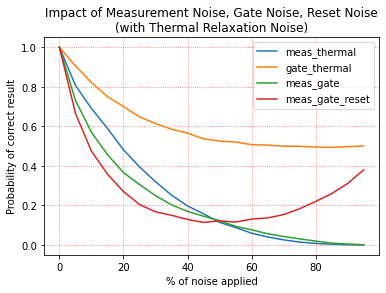

In [23]:
# Quantum Teleportation
tele_circ = QuantumCircuit(3, 3)
tele_circ.x(0)
tele_circ.barrier()

# Create an entangled state
tele_circ.h(1)
tele_circ.cx(1, 2)

tele_circ.cx(0, 1)
tele_circ.h(0)
tele_circ.barrier()

tele_circ.cx(1, 2) # if q1 is 1, apply X (01)
tele_circ.cz(0, 2) # if q0 is 1, apply Z (10)
# if q0 and q1 are both 1, apply ZX (11)

tele_circ.barrier()
tele_circ.reset([0, 1])
tele_circ.measure([0, 1, 2], [0, 1, 2])
display(tele_circ.draw(output='mpl'))

# Perform a noiseless simulation
counts_perfect = simulate(tele_circ)
display(plot_histogram(counts_perfect))

# # Run the circuit on a real quantum computer
# job = execute(tele_circ, backend=backend)
# job_monitor(job)
# result_real = job.result()
# counts_real = result_real.get_counts()
# display(plot_histogram(counts_real))

# Perform a noisy simulation (device)
result_device = execute(tele_circ, backend=sim,
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model_device).result()
counts_device = result_device.get_counts()
display(plot_histogram(counts_device))

# Probabilities of correct results under three types of noise
meas_only = []
depo_only = []
meas_depo = []

# Perform noisy simulations with pure measurement noise and depolarizing noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    meas_noise_model = build_noise_model((i / 100), 0, 0, False, 3)
    counts_meas_only = simulate(tele_circ, meas_noise_model)
    meas_only.append(counts_meas_only['100'] / 10000)
    
    depo_noise_model = build_noise_model(0, (i / 100), 0, False, 3)
    counts_depo_only = simulate(tele_circ, depo_noise_model)
    depo_only.append(counts_depo_only['100'] / 10000)
    
    meas_depo_noise_model = build_noise_model((i / 100), (i / 100), 0, False, 3)
    counts_meas_depo = simulate(tele_circ, meas_depo_noise_model)
    meas_depo.append(counts_meas_depo['100'] / 10000)

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_only)
plt.plot(range(0, 100, 5), depo_only)
plt.plot(range(0, 100, 5), meas_depo)
plt.title('Impact of Measurement Noise and Depolarizing Noise')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_only', 'depo_only', 'meas_depo'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()

# Probabilities of correct results under three types of noise
meas_thermal = []
gate_thermal = []
meas_gate = []
index = 0

# Perform noisy simulations with mixed measurement noise and gate noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    meas_noise_model = build_noise_model((i / 100), 0, 0, True, 3)
    counts_meas_thermal = simulate(tele_circ, meas_noise_model)
    meas_thermal.append(meas_only[index] * counts_meas_thermal['100'] / 10000)
    
    gate_noise_model = build_noise_model(0, (i / 100), 0, True, 3)
    counts_gate_thermal = simulate(tele_circ, gate_noise_model)
    gate_thermal.append(depo_only[index] * counts_gate_thermal['100'] / 10000)
    
    meas_gate_noise_model = build_noise_model((i / 100), (i / 100), 0, True, 3)
    counts_meas_gate = simulate(tele_circ, meas_gate_noise_model)
    meas_gate.append(meas_depo[index] * counts_meas_gate['100'] / 10000)
    
    index += 1

meas_gate_reset = []

# Perform noisy simulations with reset noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    total_noise_model = build_noise_model((i / 100), (i / 100), (i / 100), False, 3)
    counts_total = simulate(tele_circ, total_noise_model)
    meas_gate_noise_model = build_noise_model((i / 100), (i / 100), 0, True, 3)
    counts_meas_gate = simulate(tele_circ, meas_gate_noise_model)
    meas_gate_reset.append((counts_total['100'] / 10000) * (counts_meas_gate['100'] / 10000))

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_thermal)
plt.plot(range(0, 100, 5), gate_thermal)
plt.plot(range(0, 100, 5), meas_gate)
plt.title('Impact of Measurement Noise and Gate Noise\n(with Thermal Relaxation Noise)')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_thermal', 'gate_thermal', 'meas_gate'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_thermal)
plt.plot(range(0, 100, 5), gate_thermal)
plt.plot(range(0, 100, 5), meas_gate)
plt.plot(range(0, 100, 5), meas_gate_reset)
plt.title('Impact of Measurement Noise, Gate Noise, Reset Noise\n(with Thermal Relaxation Noise)')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_thermal', 'gate_thermal', 'meas_gate', 'meas_gate_reset'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()


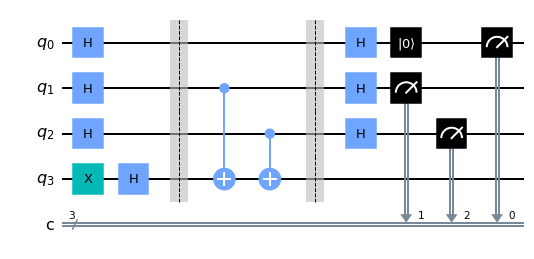

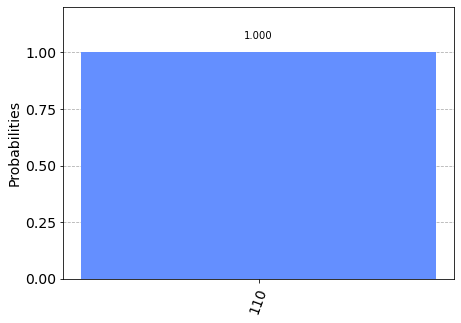

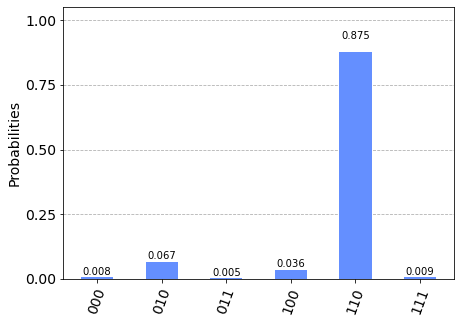

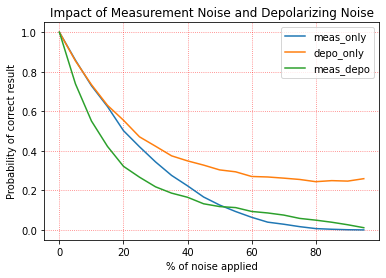

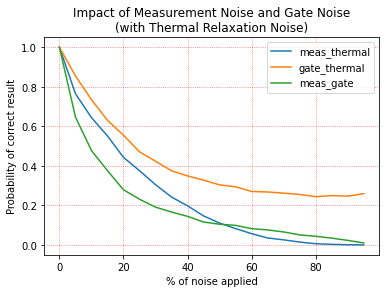

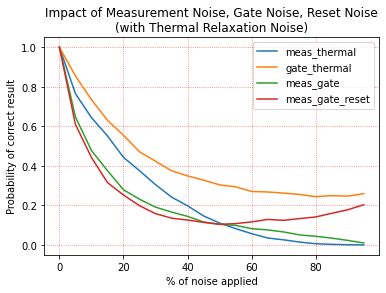

In [28]:
# Bernstein-Vazirani
secretnumber = '110'

bv_circ = QuantumCircuit(len(secretnumber)+1, len(secretnumber))

bv_circ.h(range(len(secretnumber)))
bv_circ.x(len(secretnumber))
bv_circ.h(len(secretnumber))
bv_circ.barrier()

# all 1s from last bit to first bit
for index, digit in enumerate((reversed(secretnumber))):
    if digit is '1':
        bv_circ.cx(index, len(secretnumber))
bv_circ.barrier()

bv_circ.h(range(len(secretnumber)))

bv_circ.reset(0)
bv_circ.measure(range(len(secretnumber)), range(len(secretnumber)))
display(bv_circ.draw(output='mpl'))

# Perform a noiseless simulation
counts_perfect = simulate(bv_circ)
display(plot_histogram(counts_perfect))

# # Run the circuit on a real quantum computer
# job = execute(bv_circ, backend=backend)
# job_monitor(job)
# result_real = job.result()
# counts_real = result_real.get_counts()
# display(plot_histogram(counts_real))

# Perform a noisy simulation (device)
result_device = execute(bv_circ, backend=sim,
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model_device).result()
counts_device = result_device.get_counts()
display(plot_histogram(counts_device))

# Probabilities of correct results under three types of noise
meas_only = []
depo_only = []
meas_depo = []

# Perform noisy simulations with pure measurement noise and depolarizing noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    meas_noise_model = build_noise_model((i / 100), 0, 0, False, 3)
    counts_meas_only = simulate(bv_circ, meas_noise_model)
    meas_only.append(counts_meas_only['110'] / 10000)
    
    depo_noise_model = build_noise_model(0, (i / 100), 0, False, 3)
    counts_depo_only = simulate(bv_circ, depo_noise_model)
    depo_only.append(counts_depo_only['110'] / 10000)
    
    meas_depo_noise_model = build_noise_model((i / 100), (i / 100), 0, False, 3)
    counts_meas_depo = simulate(bv_circ, meas_depo_noise_model)
    meas_depo.append(counts_meas_depo['110'] / 10000)

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_only)
plt.plot(range(0, 100, 5), depo_only)
plt.plot(range(0, 100, 5), meas_depo)
plt.title('Impact of Measurement Noise and Depolarizing Noise')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_only', 'depo_only', 'meas_depo'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()

# Probabilities of correct results under three types of noise
meas_thermal = []
gate_thermal = []
meas_gate = []
index = 0

# Perform noisy simulations with mixed measurement noise and gate noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    meas_noise_model = build_noise_model((i / 100), 0, 0, True, 3)
    counts_meas_thermal = simulate(bv_circ, meas_noise_model)
    meas_thermal.append(meas_only[index] * counts_meas_thermal['110'] / 10000)
    
    gate_noise_model = build_noise_model(0, (i / 100), 0, True, 3)
    counts_gate_thermal = simulate(bv_circ, gate_noise_model)
    gate_thermal.append(depo_only[index] * counts_gate_thermal['110'] / 10000)
    
    meas_gate_noise_model = build_noise_model((i / 100), (i / 100), 0, True, 3)
    counts_meas_gate = simulate(bv_circ, meas_gate_noise_model)
    meas_gate.append(meas_depo[index] * counts_meas_gate['110'] / 10000)
    
    index += 1

meas_gate_reset = []

# Perform noisy simulations with reset noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    total_noise_model = build_noise_model((i / 100), (i / 100), (i / 100), False, 3)
    counts_total = simulate(bv_circ, total_noise_model)
    meas_gate_noise_model = build_noise_model((i / 100), (i / 100), 0, True, 3)
    counts_meas_gate = simulate(bv_circ, meas_gate_noise_model)
    meas_gate_reset.append((counts_total['110'] / 10000) * (counts_meas_gate['110'] / 10000))

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_thermal)
plt.plot(range(0, 100, 5), gate_thermal)
plt.plot(range(0, 100, 5), meas_gate)
plt.title('Impact of Measurement Noise and Gate Noise\n(with Thermal Relaxation Noise)')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_thermal', 'gate_thermal', 'meas_gate'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_thermal)
plt.plot(range(0, 100, 5), gate_thermal)
plt.plot(range(0, 100, 5), meas_gate)
plt.plot(range(0, 100, 5), meas_gate_reset)
plt.title('Impact of Measurement Noise, Gate Noise, Reset Noise\n(with Thermal Relaxation Noise)')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_thermal', 'gate_thermal', 'meas_gate', 'meas_gate_reset'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()


In [ ]:
pi = np.pi
circ = QuantumCircuit(5,5)

circ.x(0)
circ.barrier()
circ.h(0)
circ.cp(pi/2,0,1)
circ.cp(pi/4,0,2)

circ.h(1)
circ.cp(pi/8,0,3)
circ.cp(pi/2,1,2)
circ.cp(pi/16,0,4)
circ.cp(pi/4,1,3)

circ.h(2)
circ.cp(pi/8,1,4)
circ.cp(pi/2,2,3)
circ.cp(pi/4,2,4)

circ.h(3)
circ.cp(pi/2,3,4)

circ.h(4)

circ.swap(1,3)
circ.swap(0,4)

circ.barrier()

circ.swap(0,4)
circ.swap(1,3)

circ.h(4)
circ.cp(-pi/2,3,4)
circ.h(3)
circ.cp(-pi/4,2,4)
circ.cp(-pi/2,2,3)
circ.cp(-pi/8,1,4)
circ.h(2)
circ.cp(-pi/4,1,3)
circ.cp(-pi/16,0,4)
circ.cp(-pi/2,1,2)
circ.cp(-pi/8,0,3)
circ.h(1)

circ.cp(-pi/4,0,2)

circ.cp(-pi/2,0,1)


circ.h(0)

circ.barrier()

circ.measure(0,0)
circ.measure(1,1)
circ.measure(2,2)
circ.measure(3,3)
circ.measure(4,4)
display(circ.draw('mpl'))

# Perform a noiseless simulation
counts_perfect = simulate(circ)
display(plot_histogram(counts_perfect))

# # Run the circuit on a real quantum computer
# job = execute(circ, backend=backend)
# job_monitor(job)
# result_real = job.result()
# counts_real = result_real.get_counts()
# display(plot_histogram(counts_real))

# Perform a noisy simulation (device)
result_device = execute(circ, backend=sim,
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model_device).result()
counts_device = result_device.get_counts()
display(plot_histogram(counts_device))

# Probabilities of correct results under three types of noise
meas_only = []
depo_only = []
meas_depo = []

# Perform noisy simulations with pure measurement noise and depolarizing noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    meas_noise_model = build_noise_model((i / 100), 0, 0, False, 3)
    counts_meas_only = simulate(circ, meas_noise_model)
    meas_only.append(counts_meas_only['00001'] / 10000)
    
    depo_noise_model = build_noise_model(0, (i / 100), 0, False, 3)
    counts_depo_only = simulate(circ, depo_noise_model)
    depo_only.append(counts_depo_only['00001'] / 10000)
    
    meas_depo_noise_model = build_noise_model((i / 100), (i / 100), 0, False, 3)
    counts_meas_depo = simulate(circ, meas_depo_noise_model)
    meas_depo.append(counts_meas_depo['00001'] / 10000)

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_only)
plt.plot(range(0, 100, 5), depo_only)
plt.plot(range(0, 100, 5), meas_depo)
plt.title('Impact of Measurement Noise and Depolarizing Noise')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_only', 'depo_only', 'meas_depo'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()

# Probabilities of correct results under three types of noise
meas_thermal = []
gate_thermal = []
meas_gate = []
index = 0

# Perform noisy simulations with mixed measurement noise and gate noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    meas_noise_model = build_noise_model((i / 100), 0, 0, True, 3)
    counts_meas_thermal = simulate(circ, meas_noise_model)
    meas_thermal.append(meas_only[index] * counts_meas_thermal['00001'] / 10000)
    
    gate_noise_model = build_noise_model(0, (i / 100), 0, True, 3)
    counts_gate_thermal = simulate(circ, gate_noise_model)
    gate_thermal.append(depo_only[index] * counts_gate_thermal['00001'] / 10000)
    
    meas_gate_noise_model = build_noise_model((i / 100), (i / 100), 0, True, 3)
    counts_meas_gate = simulate(circ, meas_gate_noise_model)
    meas_gate.append(meas_depo[index] * counts_meas_gate['00001'] / 10000)
    
    index += 1

meas_gate_reset = []

# Perform noisy simulations with reset noise
for i in range(0, 100, 5): # probability of noise increases from 0 to 0.95
    total_noise_model = build_noise_model((i / 100), (i / 100), (i / 100), False, 3)
    counts_total = simulate(circ, total_noise_model)
    meas_gate_noise_model = build_noise_model((i / 100), (i / 100), 0, True, 3)
    counts_meas_gate = simulate(circ, meas_gate_noise_model)
    meas_gate_reset.append((counts_total['00001'] / 10000) * (counts_meas_gate['00001'] / 10000))

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_thermal)
plt.plot(range(0, 100, 5), gate_thermal)
plt.plot(range(0, 100, 5), meas_gate)
plt.title('Impact of Measurement Noise and Gate Noise\n(with Thermal Relaxation Noise)')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_thermal', 'gate_thermal', 'meas_gate'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()

# plot the percentages of noise versus chances to get correct results
plt.plot(range(0, 100, 5), meas_thermal)
plt.plot(range(0, 100, 5), gate_thermal)
plt.plot(range(0, 100, 5), meas_gate)
plt.plot(range(0, 100, 5), meas_gate_reset)
plt.title('Impact of Measurement Noise, Gate Noise, Reset Noise\n(with Thermal Relaxation Noise)')
plt.xlabel('% of noise applied')
plt.ylabel('Probability of correct result')
plt.legend(labels=['meas_thermal', 'gate_thermal', 'meas_gate', 'meas_gate_reset'])
plt.grid(b=True, linestyle=':', color='r', alpha=0.6)
plt.show()